In [146]:
import os
import cv2
import json
import math
import torch
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchvision import transforms
import torch.nn.functional as nnf
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2






device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [147]:
def set_seed(seed_number:int=42, loader=None) -> None:

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_number)
    
    np.random.seed(seed_number)
    
    random.seed(seed_number)
    
set_seed(42)

In [148]:
class CFG:
    
    train_batch_size = 1
    test_batch_size = 1
    
    lr = 0.0001
    lr_finetune = 0.0005
    weight_decay = 1e-4
    
    epochs = 20
    epochs_finetune = 15

cfg = CFG()

In [149]:
train_img_path = '../../data/coco/train'
train_label_file = '../../data/coco/train/_annotations.coco.json'
test_img_path = '../../data/coco/test'
test_label_file = '../../data/coco/test/_annotations.coco.json'
valid_img_path = '../../data/coco/valid'
valid_label_file = '../../data/coco/valid/_annotations.coco.json'


In [150]:
with open(train_label_file) as json_file:
    train_data_dict = json.load(json_file)
    
with open(test_label_file) as json_file:
    test_data_dict = json.load(json_file)

with open(valid_label_file) as json_file:
    valid_data_dict = json.load(json_file)

train_data_dict['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 2,
 'bbox': [226, 268, 61.875, 103.875],
 'area': 6427.265625,
 'segmentation': [],
 'iscrowd': 0}

In [151]:
cat_mapping = dict() # Variable that maps class id -> class name
for category in train_data_dict['categories']:
    cat_mapping[category['id']] = category['name']

In [152]:
class Compose(object):
    def __init__(self, transforms):

        self.transforms = transforms

    def __call__(self, image, bboxes):

        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes

    
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):

        self.p = p

    def __call__(self, image, bboxes):

        if random.random() < self.p:
            image = F.hflip(image)
            width, _ = image.size
            if len(bboxes)!=0:
                bboxes = bboxes.clone()
                bboxes[:, [0, 2]] = width - bboxes[:, [2, 0]]  # Flip x_min and x_max
        return image, bboxes

    
class ToTensor(object):
    def __call__(self, image, bboxes):

        image = F.to_tensor(image)
        return image, bboxes

In [153]:
train_transform = Compose([
            RandomHorizontalFlip(p=0.5),
            ToTensor()
        ])

val_transform = Compose([
            ToTensor()
        ])

test_transform = val_transform

In [154]:
class CSGO_Dataset(Dataset):
    def __init__(self, img_path, data_dict, transform=None):

        self.img_path = img_path
        self.data_dict = data_dict
        self.transform = transform
        self.dataset = self.create_dataset()
    
    def create_dataset(self):

        dataset = []
        for element in self.data_dict["images"]:
            img_id = element['id']
            img_annotations = []
            for annotation in self.data_dict['annotations']:
                if annotation['image_id'] == img_id:
                    img_annotations.append(annotation)
            dataset.append([element['file_name'], img_annotations])
        
        return dataset
    
    def __len__(self):

        return len(self.data_dict['images'])
    
    def collate_fn(self, batch):

        images = list()
        boxes = list()
        labels = list()
        areas = list()
        image_id = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            areas.append(b[3])
            image_id.append(b[4])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, areas, image_id
    
    def __getitem__(self, idx):

        
        img = cv2.imread(os.path.join(self.img_path, self.dataset[idx][0]))            
        cat_ids = []
        bbs = []
        areas = []
        iscrowd = []
        image_id = []
        for annotation in self.dataset[idx][1]:
            cat_ids.append(annotation['category_id'])
            bbs.append(annotation['bbox'])
            areas.append(annotation['area'])
            iscrowd.append(annotation['iscrowd'])
            image_id.append(annotation['image_id'])
        cat_ids = torch.Tensor(cat_ids)
        
        areas = torch.Tensor(areas)
        iscrowd = torch.Tensor(iscrowd)
        image_id = torch.Tensor(image_id)
        
        bbs = np.array(bbs)
        for i, bb in enumerate(bbs):
            x_min, y_min, width, height = bb
            x1, y1 = x_min, y_min
            x2, y2 = x_min + width, y_min + height
            bbs[i] = np.array([x1, y1, x2, y2])
        
        bbs = torch.Tensor(bbs)
        if self.transform:
            img = Image.fromarray(img)
            img, bbs = self.transform(img, bbs)
        
        bbs = torch.from_numpy(np.array(bbs))
        cat_ids = torch.Tensor(cat_ids).long()
        
        return img, bbs, cat_ids, areas, image_id

In [155]:
train_dataset = CSGO_Dataset(train_img_path, train_data_dict, transform=train_transform)
test_dataset = CSGO_Dataset(test_img_path, test_data_dict, transform=test_transform)
valid_dataset = CSGO_Dataset(valid_img_path, valid_data_dict, transform=test_transform)

In [156]:
train_dataloader = DataLoader(train_dataset, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.test_batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.test_batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn)

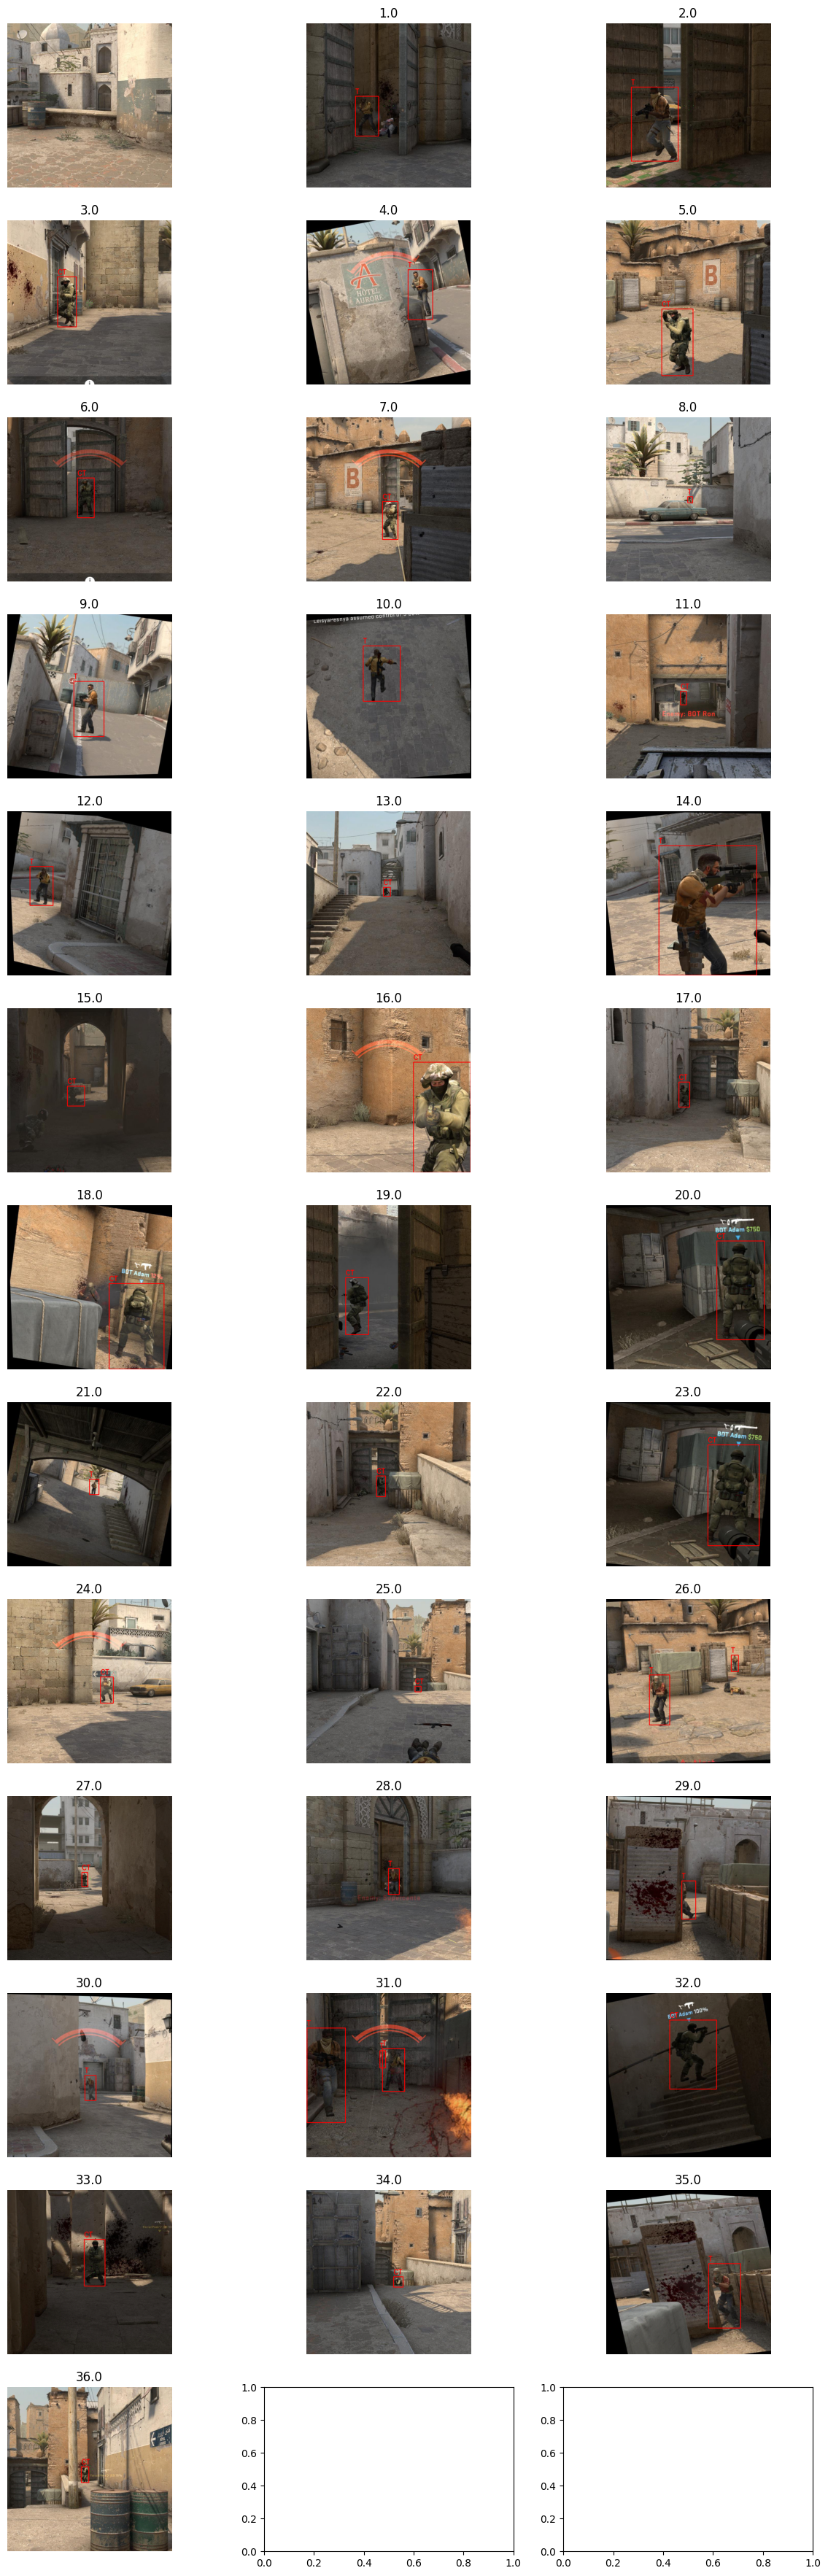

In [157]:
def plot_images_with_boxes(images, bbs, labels, image_id, class_names, ax, i, columns):

    for img, bb, lbl, img_id in zip(images, bbs, labels, image_id):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8) # Convert image from [0, 1] to [0, 255] range
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert from RGB (Matplotlib) to BGR (OpenCV)       
        
        for box, label in zip(bb, lbl): # For each bounding box and label found in the image
            x1, y1, x2, y2 = map(int, box) # Convert Tensor values in box to integers
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)  # Draw bounding box
            cv2.putText(img, class_names[int(label)], org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=(255, 0, 0), thickness=2)  # Draw class label

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for plotting
        ax[i//columns][i%columns].imshow(img)
        ax[i//columns][i%columns].axis("off")
        if(len(img_id) > 0):
            ax[i//columns][i%columns].set_title(f"{img_id[0]}")

rows = math.ceil(len(test_dataloader)/3)
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 45))
for i, (images, bbs, labels, areas, image_id) in enumerate(test_dataloader):
    plot_images_with_boxes(images, bbs, labels, image_id, cat_mapping, ax, i, columns)
plt.show()

In [158]:
class_frequencies = {cat_mapping[k]:0 for k,v in cat_mapping.items()}

for annotation in train_data_dict['annotations']:
    category_id = annotation['category_id']
    category_name = cat_mapping[category_id]
    class_frequencies[category_name] = class_frequencies[category_name] + 1

classes = list(class_frequencies.keys())
frequencies = list(class_frequencies.values())

fig = go.Figure(data=[go.Bar(x=classes, y=frequencies)])
fig.update_layout(
    title='Class Frequency Histogram',
    xaxis_title='Class Names',
    yaxis_title='Frequency',
    template='seaborn'
)

fig.show()

In [159]:
# class MyCNN(nn.Module):
#     def __init__(self):
#         super(MyCNN, self).__init__()
#         # Define your CNN layers here
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(64 * 56 * 56, 128)
#         self.fc2 = nn.Linear(128, 3)  # Assuming 3 classes for image classification

#     def forward(self, images, targets):
#         # Your forward pass logic here
#         x = self.conv1(images)
#         x_cls = x.view(batch_size, 3)

#         # Reshape for bounding box regression
#         x_reg = x.view(batch_size, num_boxes * 4)  # Assuming 4 coordinates per box
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         x = self.fc2(x)

#         # Calculate losses (replace with your actual loss functions)
#         loss_classifier = nn.CrossEntropyLoss()(x, targets['labels'])
#         loss_box_reg = nn.SmoothL1Loss()(x, targets['boxes'])

#         # Perform optimizer step (replace with your actual optimizer)
#         optimizer = optim.SGD(self.parameters(), lr=0.001)
#         optimizer.zero_grad()
#         total_loss = loss_classifier + loss_box_reg
#         total_loss.backward()
#         optimizer.step()

#         # Return training loss information
#         return {
#             'total_loss': total_loss.item(),
#             'loss_classifier': loss_classifier.item(),
#             'loss_box_reg': loss_box_reg.item()
#         }

In [160]:
import torchvision

class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        # Define your custom backbone layers here
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

class CustomHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomHead, self).__init__()
        self.fc1 = nn.Linear(in_channels * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = nnf.relu(self.fc1(x))
        x = nnf.relu(self.fc2(x))
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

def get_model(num_classes):
    # Custom backbone
    backbone = CustomBackbone()
    backbone.out_channels = 256
    
    # RPN Anchor Generator
    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    # ROI Pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )
    
    # Custom head
    head = CustomHead(backbone.out_channels, num_classes)
    
    # Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=rpn_anchor_generator,
        box_roi_pool=roi_pooler,
        box_head=head
    )
    
    return model


In [161]:
def calculate_iou(box1, box2):

    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_min_x = max(x1_min, x2_min)
    inter_min_y = max(y1_min, y2_min)
    inter_max_x = min(x1_max, x2_max)
    inter_max_y = min(y1_max, y2_max)

    inter_area = max(0, inter_max_x - inter_min_x) * max(0, inter_max_y - inter_min_y)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

In [162]:
def plot_test_predictions(image, boxes, labels, scores, class_names, true_boxes, true_labels, image_id, iou_threshold=0.7):

    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) # Convert back to [0, 255] range
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores): # For each bounding box and label found in the image
        x1, y1, x2, y2 = map(int, box)
        match = False
        match_bb = False
        for true_box, true_label in zip(true_boxes, true_labels):
            if calculate_iou(box, true_box) >= iou_threshold and label == true_label: # Bounding Box and class right
                match = True
            elif calculate_iou(box, true_box) >= iou_threshold: # Bounding Box right but class wrong
                match_bb = True
        
        text = f'{class_names[int(label)]}: {score:.2f}'
        if match:
            green = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=green, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=green, thickness=2)
        elif match_bb:
            blue = (0, 0, 255)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=blue, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=blue, thickness=2)
        else:
            red = (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=red, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=red, thickness=2)

    plt.title(f'Image {int(image_id[0])}')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [163]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, epoch):
    model.train()
    total_train_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    total_samples = 0
    
    for images, bbs, labels, areas, image_id in dataloader:
        images = images.float().to(device)
        targets = [{'boxes': bbs[i].to(device), 'labels': labels[i].to(device)} for i, bb in enumerate(bbs)]
        optimizer.zero_grad()
        
        if 0 in list(map(len, bbs)):
            continue
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        
        total_train_loss += losses.item() * images.size(0)
        loss_classifier += loss_dict['loss_classifier'].item() * images.size(0)
        loss_box_reg += loss_dict['loss_box_reg'].item() * images.size(0)
        total_samples += images.size(0)
    
    average_train_loss = total_train_loss / total_samples
    average_classifier_loss = loss_classifier / total_samples
    average_box_reg_loss = loss_box_reg / total_samples

    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}, Total Loss: {average_train_loss:.4f}, Class. Loss: {average_classifier_loss:.4f}, Box Reg. Loss: {average_box_reg_loss:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.7f}")

    return average_train_loss, average_classifier_loss, average_box_reg_loss

In [164]:
num_classes = 3
model = get_model(num_classes)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr_finetune, weight_decay=cfg.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.epochs_finetune // 2, gamma=0.1)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): CustomBackbone(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
    

In [165]:
print(device)
model.train()
# Training loop
train_losses = []
for epoch in range(cfg.epochs_finetune):
    epc_train_loss, epc_class_loss, epc_box_reg_loss = train_epoch(model, train_dataloader, optimizer, lr_scheduler, epoch)
    train_losses.append(epc_train_loss)

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0)
plt.show()

cuda


AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
checkpoint_path = 'custom_back_hea.pth'

# Save the model state dictionary and optimizer state dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)

print(f"Model checkpoint saved to {checkpoint_path}")